In [1]:
!pip install trimesh
!pip install path
!pip install thop
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
!unzip -q ModelNet10.zip;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 685.4/685.4 kB 5.6 MB/s eta 0:00:00
--2023-08-28 18:50:27--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.67
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-08-28 18:50:27--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  66.3MB/s    in 4.9s    

2023-08-28 18:50:32 (92.8 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [2]:
import trimesh
from path import Path
import numpy as np
import math
import random
import os
import torch
from glob import glob
import scipy.spatial.distance
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import plotly.graph_objects as go
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
from torchsummary import summary
from thop import profile
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
if torch.cuda.is_available():
  if_cuda=True
else:
  if_cuda=False
seed_value=0
np.random.seed(seed_value) # cpu vars
torch.manual_seed(seed_value) # cpu  vars
random.seed(seed_value) # Python
os.environ['PYTHONHASHSEED']=str(seed_value)
if if_cuda:
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # gpu vars
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
class SamplePoints:
    def randomSample(self):
        indexes = random.sample(range(self.points.shape[0]), self.npoint)
        return self.points[indexes]

    def farthestPointSample(self):
        N, D = self.points.shape
        xyz = self.points[:,:3]
        centroids = np.zeros((self.npoint,))
        distance = np.ones((N,)) * 1e10
        farthest = np.random.randint(0, N)
        for i in range(self.npoint):
            centroids[i] = farthest
            centroid = xyz[farthest, :]
            dist = np.sum((xyz - centroid) ** 2, -1)
            mask = dist < distance
            distance[mask] = dist[mask]
            farthest = np.argmax(distance, -1)
        points = self.points[centroids.astype(np.int32)]
        return points

    def normalize(self,spc):
        npc = spc - np.mean(spc, axis=0)
        npc /= np.max(np.linalg.norm(npc, axis=1))
        return npc

    def totensor(self,p):
        return torch.from_numpy(p)

    def RandomRotation(self,pc):
        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        rot_pointcloud = rot_matrix.dot(pc.T).T
        return  rot_pointcloud

    def RandomNoise(self,pc):
        noise = np.random.normal(0, 0.02, (pc.shape))
        npc = pc + noise
        return  npc

    def __init__(self,points,npoints=1024):
        self.points=points
        self.npoint=npoints

In [5]:

class ModelNet10Datset(Dataset):
    def __init__(self, root_dir, valid=False, folder="train"):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        pcd = trimesh.load(file)
        sampled_pc = trimesh.sample.sample_surface(pcd,5000)
        pc = sampled_pc[0]
        k=SamplePoints(pc)
        pc=k.farthestPointSample()
        pc=k.normalize(pc)
        if self.valid == False:
            pc=k.RandomRotation(pc)
            pc=k.RandomNoise(pc)
        pc=k.totensor(pc)
        return pc

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']

        pointcloud = self.__preproc__(pcd_path)

        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [6]:
class Tnet(nn.Module):
  def __init__(self,k=3):
    super().__init__()
    self.k=k
    self.conv1=nn.Conv1d(k,64,1)
    self.conv2=nn.Conv1d(64,128,1)
    self.conv3=nn.Conv1d(128,1024,1)
    self.fc1=nn.Linear(1024,512)
    self.fc2=nn.Linear(512,256)
    self.fc3=nn.Linear(256,k*k)

    self.bn1 = nn.BatchNorm1d(64)
    self.bn2 = nn.BatchNorm1d(128)
    self.bn3 = nn.BatchNorm1d(1024)
    self.bn4 = nn.BatchNorm1d(512)
    self.bn5 = nn.BatchNorm1d(256)

  def forward(self,input):
    bs=input.size(0)
    xb = F.relu(self.bn1(self.conv1(input)))
    xb = F.relu(self.bn2(self.conv2(xb)))
    xb = F.relu(self.bn3(self.conv3(xb)))
    pool = nn.MaxPool1d(xb.size(-1))(xb)
    flat = nn.Flatten(1)(pool)
    xb = F.relu(self.bn4(self.fc1(flat)))
    xb = F.relu(self.bn5(self.fc2(xb)))

    init=torch.eye(self.k,requires_grad=True).repeat(bs,1,1)
    if xb.is_cuda:
      init=init.cuda()
    matrix=self.fc3(xb).view(-1,self.k,self.k)+init
    return matrix

class Transform(nn.Module):
  def __init__(self):
    super().__init__()
    self.input_transform=Tnet(k=3)
    self.feature_transform=Tnet(k=64)
    self.conv1=nn.Conv1d(3,64,1)
    self.conv2=nn.Conv1d(64,128,1)
    self.conv3=nn.Conv1d(128,1024,1)
    self.bn1=nn.BatchNorm1d(64)
    self.bn2=nn.BatchNorm1d(128)
    self.bn3=nn.BatchNorm1d(1024)

  def forward(self,input):
    mat3x3=self.input_transform(input)
    xb=torch.bmm(torch.transpose(input,1,2),mat3x3).transpose(1,2)
    xb=F.relu(self.bn1(self.conv1(xb)))

    mat64x64=self.feature_transform(xb)
    xb=torch.bmm(torch.transpose(xb,1,2),mat64x64).transpose(1,2)

    xb=F.relu(self.bn2(self.conv2(xb)))
    xb=self.bn3(self.conv3(xb))
    xb=nn.MaxPool1d(xb.size(-1))(xb)
    out=nn.Flatten(1)(xb)
    return out,mat3x3,mat64x64

class PointNet(nn.Module):
  def __init__(self, classes = 10):
    super().__init__()
    self.transform=Transform()
    self.fc1=nn.Linear(1024,512)
    self.fc2=nn.Linear(512,256)
    self.fc3=nn.Linear(256,classes)

    self.bn1=nn.BatchNorm1d(512)
    self.bn2=nn.BatchNorm1d(256)
    self.dropout=nn.Dropout(p=0.3)
    self.logsoftmax=nn.LogSoftmax(dim=1)

  def forward(self,input):
    xb,mat3x3,mat64x64=self.transform(input)
    xb=F.relu(self.bn1(self.fc1(xb)))
    xb=F.relu(self.bn2(self.dropout(self.fc2(xb))))
    output=self.fc3(xb)
    return self.logsoftmax(output),mat3x3,mat64x64

In [7]:

def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()  # Classification loss
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [10]:
k=sum(p.numel() for p in pointnet.parameters() if p.requires_grad)
k

3463763

In [11]:
path=Path("ModelNet10")
train_dataset = ModelNet10Datset(path)
valid_dataset = ModelNet10Datset(path, valid=True, folder='test')
classes = {i: cat for cat, i in train_dataset.classes.items()}
classes

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [12]:
print('Train dataset size: ', len(train_dataset))
print('Valid dataset size: ', len(valid_dataset))
print('Number of classes: ', len(train_dataset.classes))
print('Sample pointcloud shape: ', train_dataset[0]['pointcloud'].size())
print('Class: ',classes[train_dataset[0]['category']])

Train dataset size:  3991
Valid dataset size:  908
Number of classes:  10
Sample pointcloud shape:  torch.Size([1024, 3])
Class:  bathtub


In [14]:
batch_size=128
epochs=5
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True,drop_last=False)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size,drop_last=False,shuffle=True)

In [15]:
def train(model, train_loader, val_loader=None,  epochs=5, save=True):
    for epoch in range(epochs):
        pointnet.train()
        running_loss = 0.0
        mean_correct=[]
        i=0
        for data in tqdm(train_loader,ncols= 100):
            inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            pred_choice=outputs.data.max(1)[1]
            correct=pred_choice.eq(labels.data).cpu().sum()
            mean_correct.append(correct.item()/float(batch_size))
            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:
              print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f mean accuracy: %f' %
                (epoch + 1, i + 1, len(train_loader), running_loss / 10, np.mean(mean_correct)))
              running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        with torch.no_grad():
            for data in val_loader:
                inputs, labels = data['pointcloud'].to(device).float(), data['category'].to(device)
                outputs, __, __ = pointnet(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100. * correct / total
        print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

In [16]:
train(pointnet, train_loader, valid_loader, 5, save=True)

100%|███████████████████████████████████████████████████████████████| 32/32 [21:01<00:00, 39.42s/it]


Valid accuracy: 30 %


100%|███████████████████████████████████████████████████████████████| 32/32 [21:04<00:00, 39.50s/it]


Valid accuracy: 71 %


100%|███████████████████████████████████████████████████████████████| 32/32 [20:55<00:00, 39.23s/it]


Valid accuracy: 65 %


100%|███████████████████████████████████████████████████████████████| 32/32 [20:51<00:00, 39.11s/it]


Valid accuracy: 75 %


100%|███████████████████████████████████████████████████████████████| 32/32 [21:12<00:00, 39.75s/it]


Valid accuracy: 75 %


100%|██████████| 8/8 [05:36<00:00, 42.07s/it]


Valid accuracy: 76 %


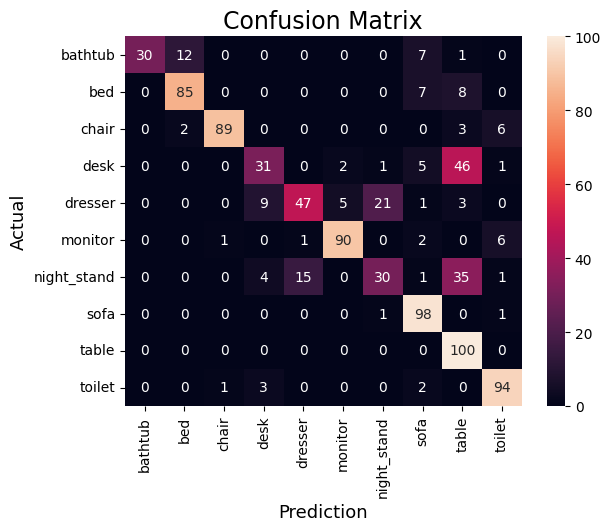

In [17]:
epochs=4
class PredictAndPlot:
    def __init__(self):
        self.classes = {i: cat for cat, i in valid_dataset.classes.items()}
        correct = total = 0
        pointnet = PointNet()
        pointnet.load_state_dict(torch.load("save_"+str(epochs)+".pth",map_location=torch.device('cpu')))
        pointnet.eval()
        self.predicted = []
        self.actual = []
        with torch.no_grad():
            for data in tqdm(valid_loader):
                inputs, labels = data['pointcloud'].float(), data['category']
                outputs,__,__ = pointnet(inputs.transpose(1,2))
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                self.predicted += list(predicted.numpy())
                self.actual += list(labels.numpy())
        val_acc = 100. * correct / total
        print('Valid accuracy: %d %%' % val_acc)
        self.plot()

    def plot(self):
        cm = confusion_matrix(self.actual,self.predicted)
        sns.heatmap(cm,
            annot=True,
            fmt='g',
            xticklabels=self.classes.values(),
            yticklabels=self.classes.values())
        plt.xlabel('Prediction',fontsize=13)
        plt.ylabel('Actual',fontsize=13)
        plt.title('Confusion Matrix',fontsize=17)
        plt.show()

k=PredictAndPlot()